[*********************100%***********************]  20 of 20 completed
/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


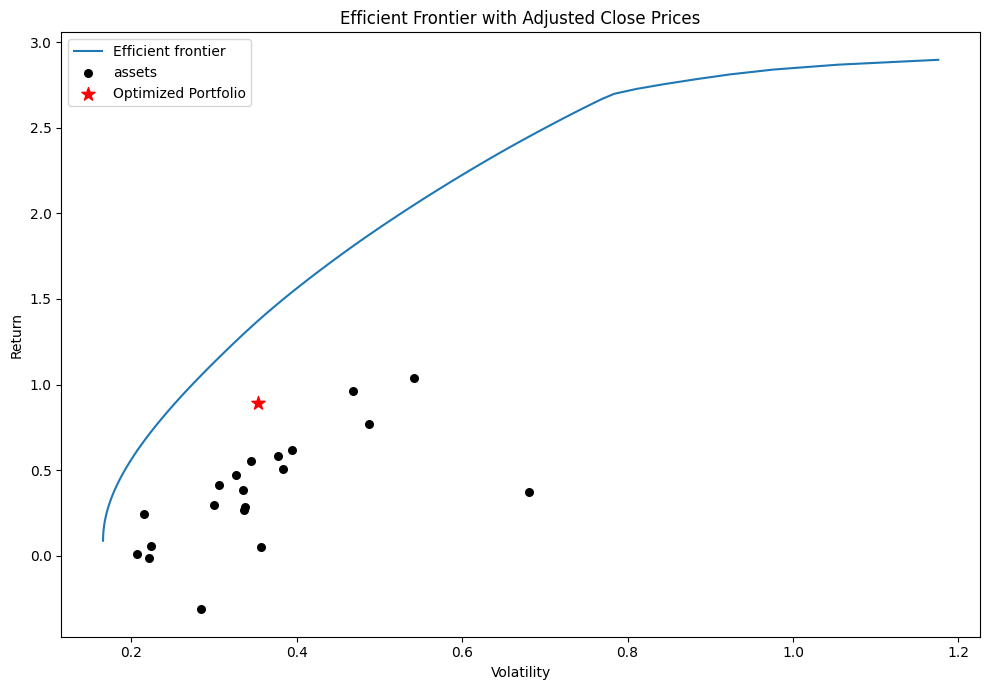

Optimized Portfolio Weights:
OrderedDict([('AAPL', -0.00016), ('ADBE', 0.10026), ('AMZN', 0.10022), ('BAC', 0.09983), ('DIS', -0.05545), ('GOOGL', 0.03744), ('HD', 0.07232), ('JNJ', -0.02007), ('JPM', 0.12381), ('KO', -0.01298), ('MA', 0.02053), ('META', 0.19914), ('MSFT', 0.06804), ('NFLX', 0.14712), ('NVDA', 0.1966), ('PFE', -0.13025), ('PG', -0.03516), ('TSLA', -0.00307), ('V', 0.03152), ('VZ', 0.0603)])


In [44]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, objective_functions
from pypfopt.plotting import plot_efficient_frontier

# Define the stock tickers
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "META", "TSLA", "NVDA", "JPM", "V", "MA",
    "JNJ", "PG", "DIS", "HD", "BAC", "VZ", "PFE", "KO", "ADBE", "NFLX"
]

# Download historical data with auto_adjust set to False
data = yf.download(tickers, start="2020-01-01", end="2024-01-01", auto_adjust=False)

# Check if 'Adj Close' is in the columns
if 'Adj Close' not in data.columns.levels[0]:
    raise ValueError("'Adj Close' column is missing from the downloaded data. Ensure that auto_adjust is set to False.")

# Extract the 'Adj Close' prices
adj_close = data['Adj Close'].dropna(how='all')

# Calculate expected returns and the sample covariance matrix
mu = expected_returns.ema_historical_return(adj_close, span=180)
S = risk_models.sample_cov(adj_close)

# Optimize portfolio
ef = EfficientFrontier(mu, S, weight_bounds=(-0.5, 0.5))
ef.add_objective(objective_functions.L2_reg, gamma=1)
weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()

# Plot efficient frontier
ef_plot = EfficientFrontier(mu, S, weight_bounds=(-0.5, 0.5))
fig, ax = plt.subplots(figsize=(10, 7))
plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Mark the optimized portfolio
ret, vol, _ = ef.portfolio_performance()
ax.scatter(vol, ret, marker="*", color="r", s=100, label="Optimized Portfolio")
plt.title("Efficient Frontier with Adjusted Close Prices")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Print cleaned weights
print("Optimized Portfolio Weights:")
print(cleaned_weights)


<ipython-input-48-4201fed080bf>:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


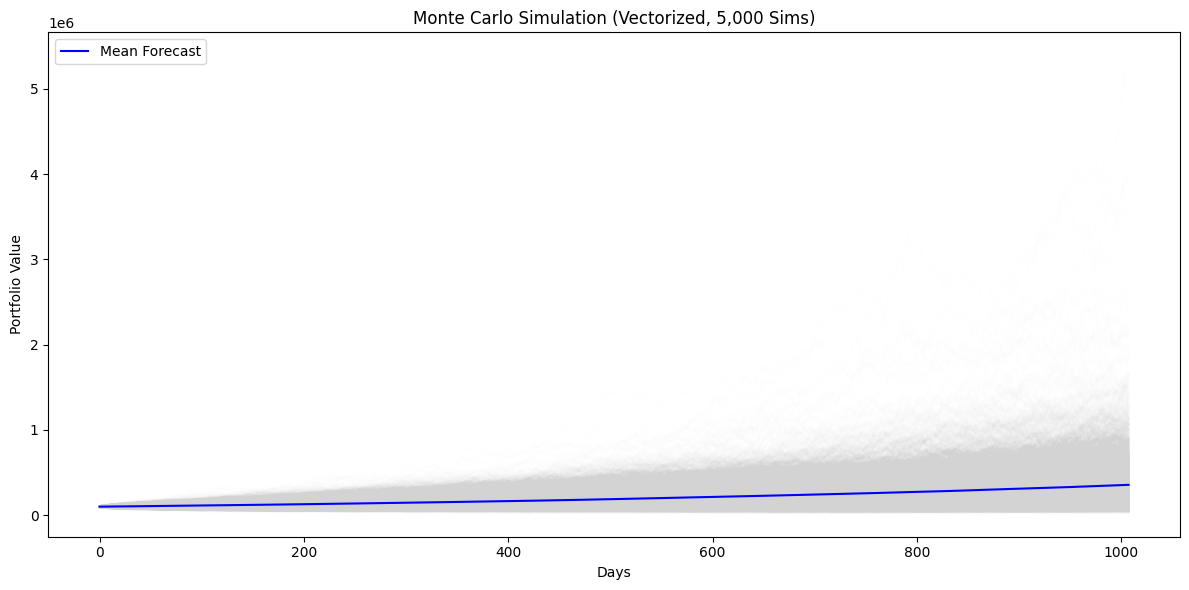

Final portfolio values after 4 years for 5000 simulations:
[155268.5084937  156575.71386885 301558.67987002 ...  94768.56844435
 144176.01161344  57087.14353351]

Portfolio Value Statistics:
Mean final value: $355,721.53
Minimum final value: $18,906.66
Maximum final value: $5,393,646.71
Standard Deviation of final values: $290,621.04


In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Number of simulations and forecast horizon
num_simulations = 5000  # or 10000 if you prefer
trading_days = 252 * 4  # 4 years

# Convert weights from dict to array
weights_array = np.array(list(cleaned_weights.values()))

# Get daily returns and calculate mean + covariance
daily_returns = adj_close.pct_change().dropna()
mean_returns = daily_returns.mean().values
cov_matrix = daily_returns.cov().values

# Set initial portfolio value
initial_portfolio_value = 100000

# Vectorized Monte Carlo Simulation
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix,
                                                        (num_simulations, trading_days))

# Convert to portfolio returns using dot product with weights
portfolio_daily_returns = np.einsum('ijk,k->ij', simulated_daily_returns, weights_array)

# Cumulative returns (product of daily returns)
cumulative_returns = np.cumprod(1 + portfolio_daily_returns, axis=1)

# Scale to initial portfolio value
portfolio_values = cumulative_returns * initial_portfolio_value

# Plot the simulation paths
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values.T, color='lightgray', alpha=0.01)
plt.plot(portfolio_values.mean(axis=0), color='blue', label='Mean Forecast')
plt.title("Monte Carlo Simulation (Vectorized, 5,000 Sims)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()

# Print final portfolio values (for each simulation)
final_values = portfolio_values[:, -1]
print(f"Final portfolio values after 4 years for {num_simulations} simulations:")
print(final_values)

# Display summary statistics
print(f"\nPortfolio Value Statistics:")
print(f"Mean final value: ${final_values.mean():,.2f}")
print(f"Minimum final value: ${final_values.min():,.2f}")
print(f"Maximum final value: ${final_values.max():,.2f}")
print(f"Standard Deviation of final values: ${final_values.std():,.2f}")


In [50]:
# Percentile threshold for 95% confidence level
confidence_level = 0.95
VaR_threshold_index = int((1 - confidence_level) * num_simulations)  # 5th percentile for 95% confidence

# Sort the final portfolio values
sorted_final_values = np.sort(final_values)

# Calculate 95% VaR (5th percentile)
VaR_95 = sorted_final_values[VaR_threshold_index]

# Calculate Expected Shortfall (ES) as the mean of the worst 5% values
ES_95 = np.mean(sorted_final_values[:VaR_threshold_index])

# Print the results
print(f"95% Value at Risk (VaR): ${initial_portfolio_value - VaR_95:,.2f}")
print(f"95% Expected Shortfall (ES): ${initial_portfolio_value - ES_95:,.2f}")


95% Value at Risk (VaR): $13,620.65
95% Expected Shortfall (ES): $33,083.27


<ipython-input-51-7cbd444c1f8c>:40: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


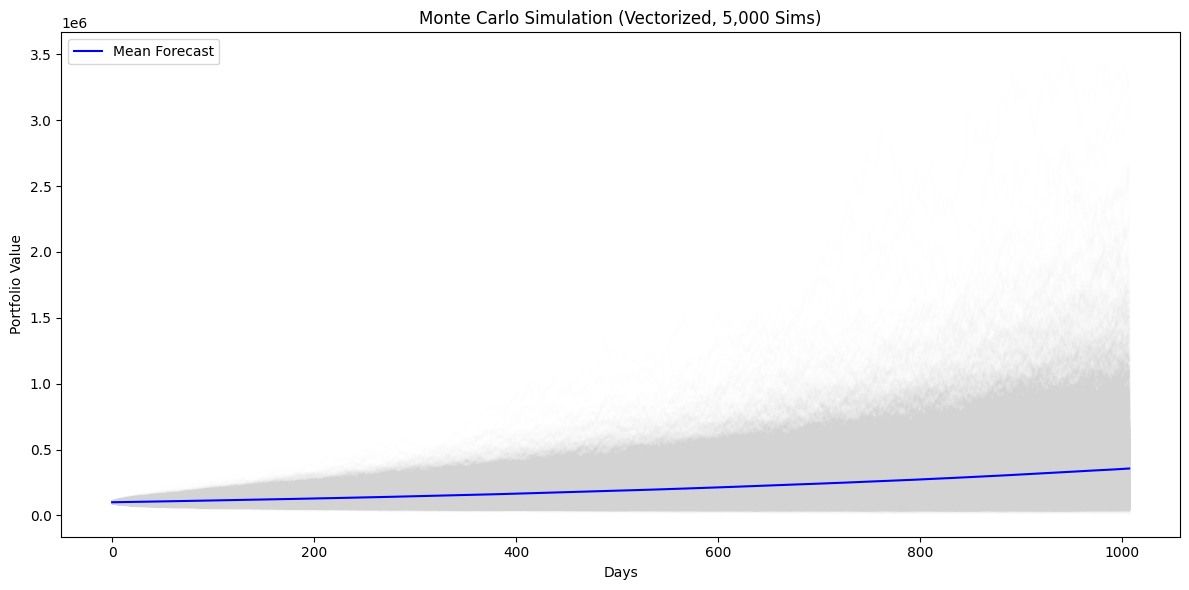

Final portfolio values after 4 years for 10000 simulations:
[881516.86550497 234376.61276587 274161.76763855 ... 209386.74914053
 332336.83813536  76956.08551413]

Portfolio Value Statistics:
Mean final value: $356,337.09
Minimum final value: $13,674.95
Maximum final value: $3,282,386.31
Standard Deviation of final values: $284,946.26


In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Number of simulations and forecast horizon
num_simulations = 10000  # or 10000 if you prefer
trading_days = 252 * 4  # 4 years

# Convert weights from dict to array
weights_array = np.array(list(cleaned_weights.values()))

# Get daily returns and calculate mean + covariance
daily_returns = adj_close.pct_change().dropna()
mean_returns = daily_returns.mean().values
cov_matrix = daily_returns.cov().values

# Set initial portfolio value
initial_portfolio_value = 100000

# Vectorized Monte Carlo Simulation
simulated_daily_returns = np.random.multivariate_normal(mean_returns, cov_matrix,
                                                        (num_simulations, trading_days))

# Convert to portfolio returns using dot product with weights
portfolio_daily_returns = np.einsum('ijk,k->ij', simulated_daily_returns, weights_array)

# Cumulative returns (product of daily returns)
cumulative_returns = np.cumprod(1 + portfolio_daily_returns, axis=1)

# Scale to initial portfolio value
portfolio_values = cumulative_returns * initial_portfolio_value

# Plot the simulation paths
plt.figure(figsize=(12, 6))
plt.plot(portfolio_values.T, color='lightgray', alpha=0.01)
plt.plot(portfolio_values.mean(axis=0), color='blue', label='Mean Forecast')
plt.title("Monte Carlo Simulation (Vectorized, 5,000 Sims)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.legend()
plt.tight_layout()
plt.show()

# Print final portfolio values (for each simulation)
final_values = portfolio_values[:, -1]
print(f"Final portfolio values after 4 years for {num_simulations} simulations:")
print(final_values)

# Display summary statistics
print(f"\nPortfolio Value Statistics:")
print(f"Mean final value: ${final_values.mean():,.2f}")
print(f"Minimum final value: ${final_values.min():,.2f}")
print(f"Maximum final value: ${final_values.max():,.2f}")
print(f"Standard Deviation of final values: ${final_values.std():,.2f}")


In [52]:
# Percentile threshold for 95% confidence level
confidence_level = 0.95
VaR_threshold_index = int((1 - confidence_level) * num_simulations)  # 5th percentile for 95% confidence

# Sort the final portfolio values
sorted_final_values = np.sort(final_values)

# Calculate 95% VaR (5th percentile)
VaR_95 = sorted_final_values[VaR_threshold_index]

# Calculate Expected Shortfall (ES) as the mean of the worst 5% values
ES_95 = np.mean(sorted_final_values[:VaR_threshold_index])

# Print the results
print(f"95% Value at Risk (VaR): ${initial_portfolio_value - VaR_95:,.2f}")
print(f"95% Expected Shortfall (ES): ${initial_portfolio_value - ES_95:,.2f}")


95% Value at Risk (VaR): $13,010.64
95% Expected Shortfall (ES): $33,335.85


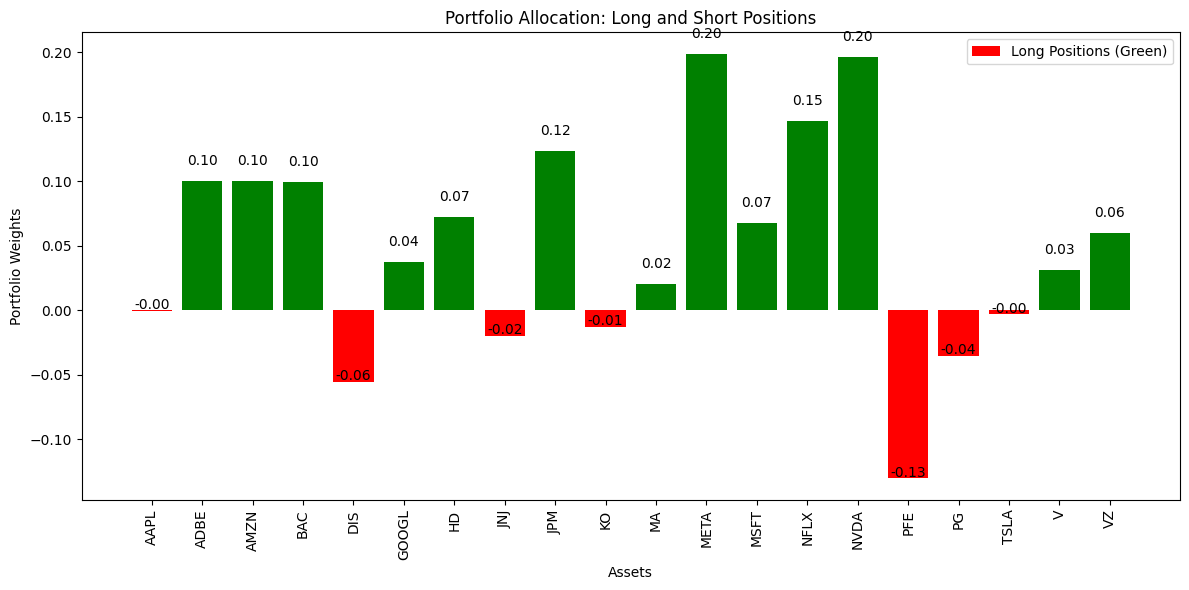

In [53]:
import matplotlib.pyplot as plt

# Extract assets (tickers) and their corresponding weights
assets = list(cleaned_weights.keys())
weights = np.array(list(cleaned_weights.values()))

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot a bar chart for the portfolio weights
colors = ['green' if weight > 0 else 'red' for weight in weights]
ax.bar(assets, weights, color=colors)

# Add labels and title
ax.set_xlabel('Assets')
ax.set_ylabel('Portfolio Weights')
ax.set_title('Portfolio Allocation: Long and Short Positions')

# Annotate each bar with the corresponding weight
for i, weight in enumerate(weights):
    ax.text(i, weight + 0.01, f"{weight:.2f}", ha='center', va='bottom' if weight > 0 else 'top', color='black')

# Show legend
ax.legend(['Long Positions (Green)', 'Short Positions (Red)'])

# Rotate asset labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()
